# Using Faiss

In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import joblib

2024-07-11 15:18:44.027612: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 15:18:44.030939: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 15:18:44.041370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 15:18:44.063515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 15:18:44.063542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 15:18:44.075993: I tensorflow/core/platform/cpu_feature_guard.cc:

In [1]:
import os

# Construct the absolute file path
file_path = '../dataset/Product_Explanation.txt'
# Initialize lists to store the parsed data
product_ids = []
descriptions = []

with open(file_path, 'r') as file:
    for line in file:  # Adjust the range to read more lines if needed
        #print(line)
        product_id, description = line.strip().split(';', 1)
        #print(product_id ,"+", description)
        product_ids.append(product_id)
        descriptions.append(description)
print(len(product_ids))
# Open and read the file

1800


In [96]:
file_path = '../dataset/Product_Categories.txt'

# Initialize lists to store the parsed data
categories = []
turkish_lower_mapping = str.maketrans('İI', 'ii')

with open(file_path, 'r') as file:
    for line in file:  # Adjust the range to read more lines if needed
        #print(line)
        _, category = line.strip().split(';', 1)
        category = category.strip()
        if '>' in category:
            category = category.split('>')[-1]  # Take the last segment after splitting by '>'
        #print(category)
        category = category.lower().translate(turkish_lower_mapping)  # Lower with Turkish chars
        category = category.strip()  # To remove empty char
        categories.append(category)
        
print(len(categories))


1800


In [97]:
#find unique categories

# remove empty and null category
filtered_categories = []
filtered_id = []
filtered_desc = []

for i in range(len(categories)):
    if categories[i] != '' and categories[i] != 'null' and descriptions[i] != '' and descriptions[i] != 'null':
        filtered_categories.append(categories[i])
        filtered_id.append(product_ids[i])
        filtered_desc.append(descriptions[i])

unique_categories = list(set(filtered_categories))
print(len(unique_categories))

555


In [98]:
remove_list = [
    ["bilgisayar bileşenleri", "bilgisayar ürünleri", "oem ürünleri", "oem & çevre birimleri", "bilgisayar bileşenleri (oem)", "oem"],
    ["çevre birimleri", "bilgisayar parçaları", "çevre birimi"],
    ["televizyon", "televizyonlar", "led tv", "tv & görüntü sistemleri"],
    ["bilgisayar", "pc", "kişisel bilgisayarlar", "bilgisayarlar", "bi̇lgi̇sayar"],
    ["yazılım","yazılım ürünleri", "yazılım ve hizmetler"],
    ["oyun - hobi","hobi & oyun konsolları", "oyun & oyun konsolu"],
    ["hafıza kartları", "hafıza kartı"],
    ["ütü","ütüler"],
    ["ekran kartı", "ekran kartları"],
    ["monitör", "monitörler"],
    ["yazıcılar",'yazıcı/tarayıcı/fax',"yazıcı"],
    ['cep telefonu','cep telefonları','telefon']
]


for i in range(len(filtered_categories)):
    for j in range(len(remove_list)):
        if filtered_categories[i] in remove_list[j]:
                filtered_categories[i] = remove_list[j][0]
unique_categories = list(set(filtered_categories))

            

In [99]:
len(filtered_categories)

1466

In [100]:
print(unique_categories)

['aksesuar', 'iphone 6 plus 16gb gümüş - apple türkiye garantili', 'ofis programları', 'xigmatek', 'tonerler', 'powersonic', 'depolama ürünleri', 'güç kaynakları (power supply)', 'nas yedekleme üniteleri', 'i̇şlemci soğutucusu', 'seg', 'inca iwm-221rsk siyah kırmızı 2.4ghz kablosuz nano mouse', 'iphone', 'ofis yazılımları', 'compact fotoğraf makineleri', 'samsung g850 galaxy alpha 16 gb cep telefonu', 'buhar kazanlı ütüler', 'güç kablosu', 'korkmaz a409 dynamica katı meyve sıkacağı', 'ekia', 'usb kabloları', 'hd alıcılar', 'yazıcı kabloları', '16 gb', 'ggmm', 'kablolar & antenler', 'network kablo', 'tripod', 'sandisk', 'overclock', 'slr fotoğraf makinesi', 'tablet kılıf', 'tablet çantaları', 'mürekkep püskürtmeli yazıcılar', 'hp pavilion k0w08ea touch ultrabook', 'brother', 'viewsonic', 'bilgisayar oyunları', 'masaüstü telefonlar', 'wd', 'kartuş ve tonerler', 'harddisk ve ssd', 'kablosuz mouse', 'çok i̇şlevli yazıcı', 'ipod', 'casio', 'epson', 'kablo - sarf malzemeler', 'diş fırçaları'

In [101]:
from collections import Counter


category_counts = Counter(filtered_categories)

# Step 2: Get the 15 most common categories
most_common_categories = category_counts.most_common(15)

# Step 3: Append these categories to a new list
most_frequent_15 = [category for category, count in most_common_categories]

print(most_frequent_15)

['samsung', 'kartuş', 'monitör', 'cep telefonu', 's-link', 'asus', 'toner', 'hp', 'televizyon', 'mouse', 'philips', 'tablet', 'hoparlörler', 'akıllı telefonlar', 'sony']


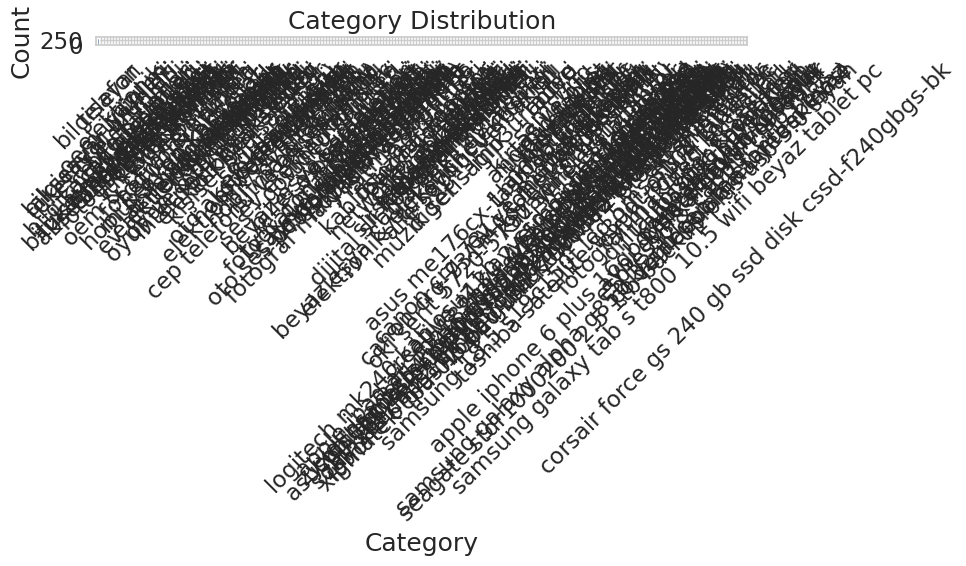

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
file_path = '../v1/Product_Explanations.csv'
data = pd.read_csv(file_path, encoding='utf-8')

# Assuming 'Categories' are categorical data, you can plot a bar chart to visualize their distribution
category_counts = data['Categories'].value_counts()
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [102]:
from tabulate import tabulate

# Printing all categories and their counts in descending order in a table format
headers = ['Category', 'Count']
table_data = [(category, count) for category, count in category_counts.items()]
table = tabulate(table_data, headers=headers, tablefmt='pretty')
print("Categories and their counts in descending order:")
#print(data["Categories"])
print(table)

Categories and their counts in descending order:
+---------------------------------------------------------------------------------------------+-------+
|                                          Category                                           | Count |
+---------------------------------------------------------------------------------------------+-------+
|                                  taşınabilir bilgisayarlar                                  |   5   |
|                                            apple                                            |  13   |
|                                           samsung                                           |  33   |
|                                           philips                                           |  18   |
|                                           monitör                                           |  29   |
|                                      taşınabilir disk                                       |   5   |
|              

In [13]:
# creating dataframe with three rows (name,description,categories)
column_names = ['id','description','categories']
df = pd.DataFrame(columns = column_names)


In [14]:
df = pd.DataFrame(list(zip(product_ids,descriptions,categories)) ,columns = column_names)
df = df.dropna(subset=['description'])  # Drop rows where 'description' is NaN
df = df[df['description'] != ''] 
df = df[df['description'] != 'null'] 

# Reset index
df = df.reset_index(drop=True)

In [15]:
cat = pd.DataFrame(df['categories'].to_list()) # listing the categories seperately
cat.head()

,0,1,2,3,4
0,bilgisayar,taşınabilir bilgisayarlar,None,None,None
1,cep telefonu,apple,None,None,None
2,cep telefonu,samsung,None,None,None
3,ev elektroniği,televizyon,samsung,None,None
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips


In [16]:

# finding total unique categories/classes from which our prediction will belong too
category_0 = cat[0].unique()
category_1 = cat[1].unique()
category_2 = cat[2].unique()
category_3 = cat[3].unique()
category_4 = cat[4].unique()

cates = np.concatenate([category_0, category_1, category_2,category_3,category_4])
cates = list(dict.fromkeys(cates))
cates = [x for x in cates if x is not None] # remove None
len(cates) # number of unique classes/categories

928

In [17]:
cat = pd.concat([cat,pd.DataFrame(columns = list(cates))]) # concatnate categories/classes to original dataframe
cat.fillna(0, inplace = True) # fill with zero
cat.head()

/tmp/ipykernel_96932/3831650490.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cat.fillna(0, inplace = True) # fill with zero


,0,1,2,3,4,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,bilgisayar,taşınabilir bilgisayarlar,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cep telefonu,apple,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cep telefonu,samsung,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ev elektroniği,televizyon,samsung,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:

# filling attendence for all the categories/classes
for i in range(5):
  row = 0
  for category in cat[i]:
    if category!= 0:
      cat.loc[row,category] = 1 # loc is label-based, which means that you have to specify rows and columns based on their row and column labels.
    row = row + 1
# iloc is integer position-based, so you have to specify rows and columns by their integer position values (0-based integer position)
     
cat.head()

,0,1,2,3,4,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,bilgisayar,taşınabilir bilgisayarlar,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cep telefonu,apple,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cep telefonu,samsung,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ev elektroniği,televizyon,samsung,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df2 = pd.concat([df['id'],df['description'],cat.loc[:,"bilgisayar":]],axis=1) # creating new dataframe which contains name of product,description and categories it belong to
df2.head()
     

,id,description,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,fotoğraf / elektronik,küçük ev aletleri,televizyon,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,462,HP Pavilion 11-n000nt Pentium N3540 4GB 750GB ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1286,STOKTAN AYNI GÜN TESLİM AYNI GÜN KARGO iPhone ...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1290,Ağırlık (Gr.) 115 Boyut (mm.) 132.4 x 65.5 x 6...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1300,"ÖZELLİKLER Ekran Ekran Boyutu 48"" Ekran Boyutu...",0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1665,Ürün Kodu : 40061255166 Genel Özellikler Panel...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
bar_plot = pd.DataFrame()
bar_plot['category'] = df2.columns[2:] # column name, which are categories
bar_plot['count'] = df2.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head() # Top 5 most occuring categories

,category,count
0,bilgisayar,422
1,bilgisayar bileşenleri,239
2,çevre birimleri,129
3,cep telefonu,92
4,aksesuar ürünleri,66


/tmp/ipykernel_96932/207619530.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
/tmp/ipykernel_96932/207619530.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
/tmp/ipykernel_96932/207619530.py:10: UserWarning: The palette list has more values (928) than needed (100), which may not be intended.
  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])


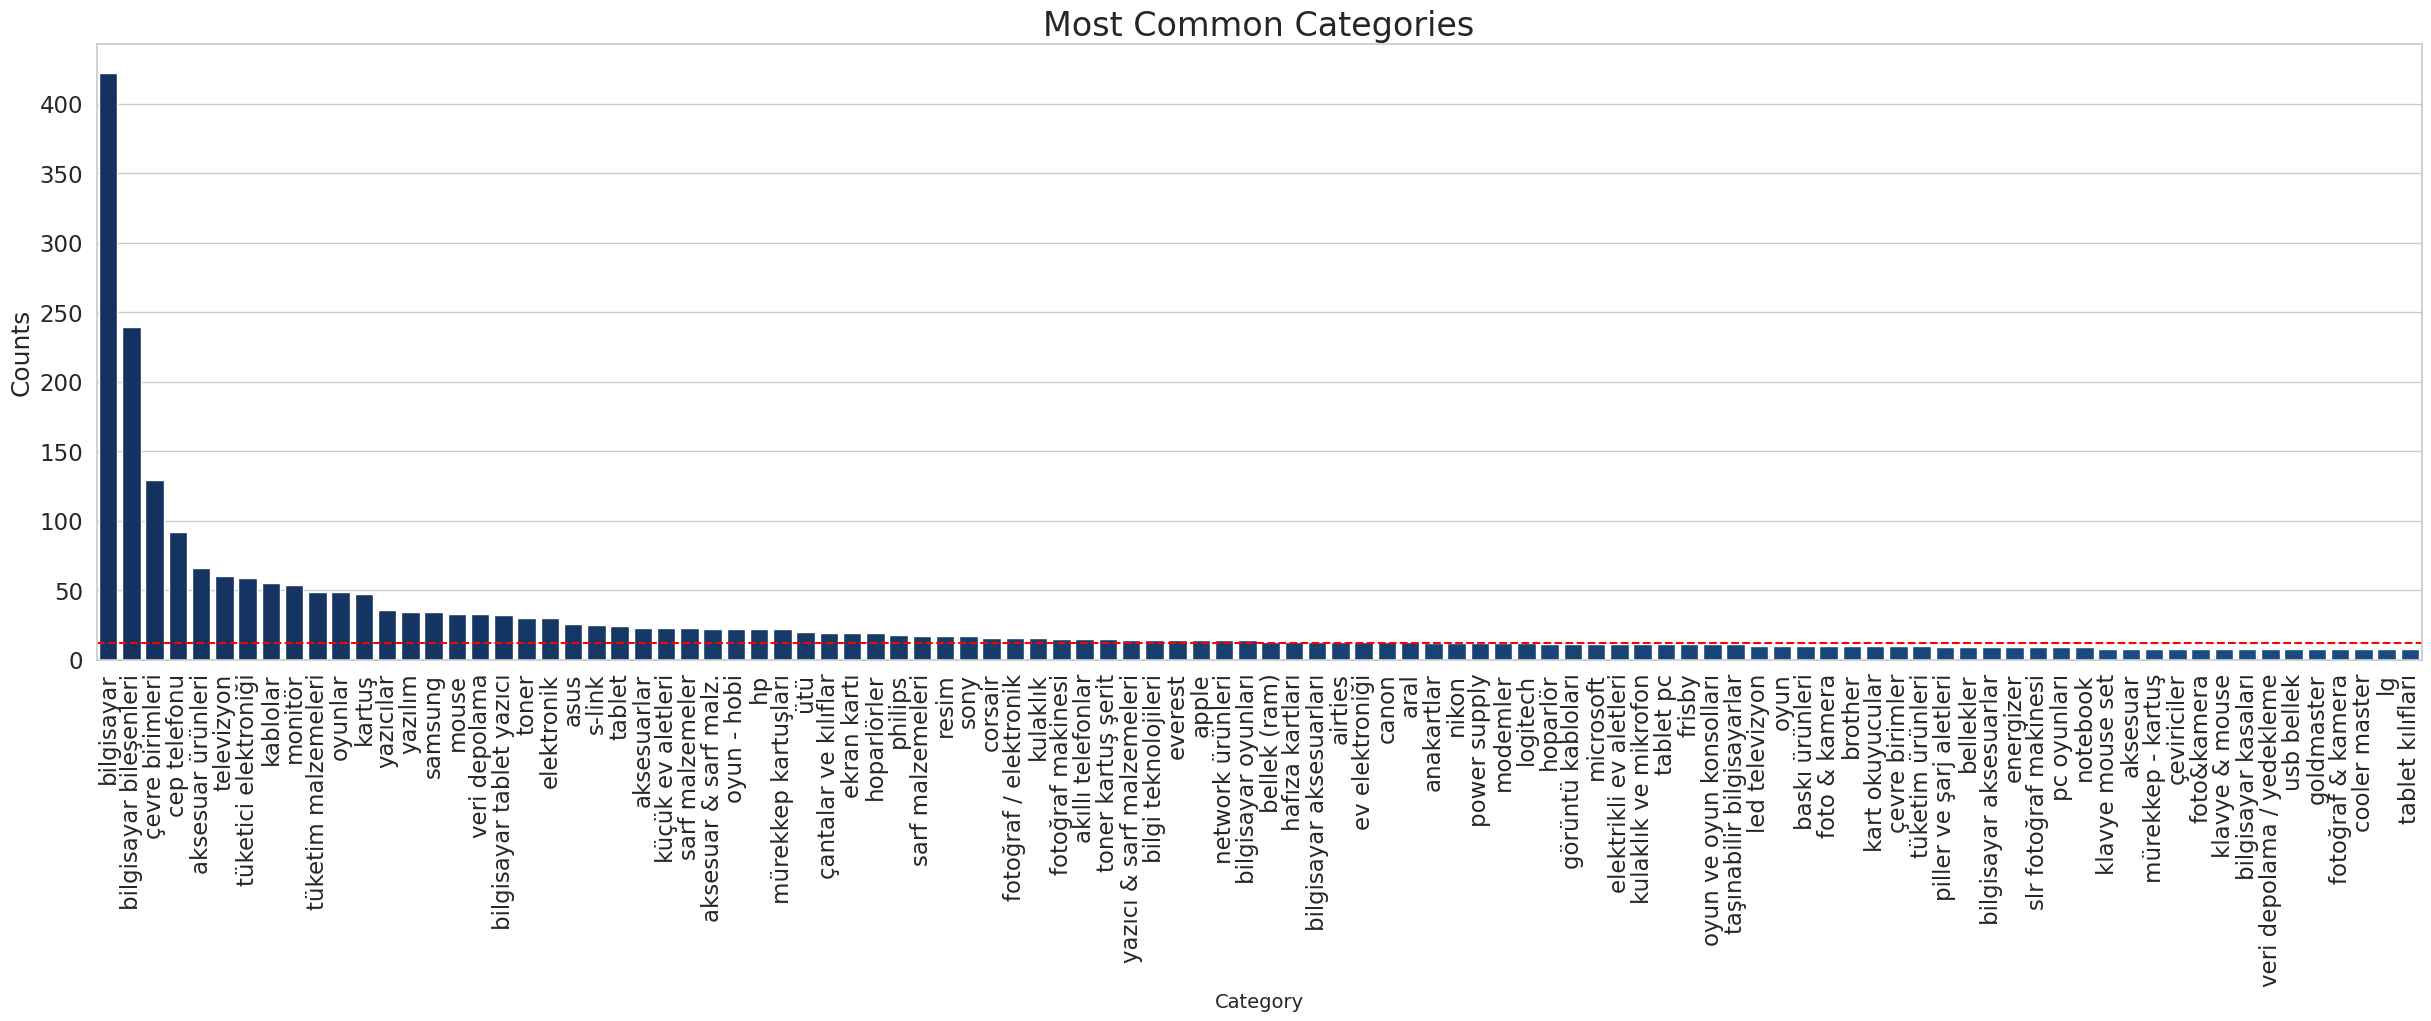

In [21]:
threshold = 12  # Trashold value

plt.figure(figsize=(30, 8))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()

sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most Common Categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

In [22]:
threshold = 12 

warnings.filterwarnings('ignore')

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>threshold]
categories = main_categories['category'].values
categories = np.append(categories,'Others')
not_category = []
df2['Others'] = 0

for i in df2.columns[2:]:
    if i not in categories:
        df2['Others'][df2[i] == 1] = 1
        not_category.append(i)

df2.drop(not_category, axis=1, inplace=True)

df2.shape

(1482, 60)

In [27]:
# Get the list of column names
second_dimension_columns = df2.columns.tolist()
category =second_dimension_columns[2:]
# Print the list
print(category)


['bilgisayar', 'cep telefonu', 'ev elektroniği', 'bilgisayar bileşenleri', 'fotoğraf / elektronik', 'küçük ev aletleri', 'televizyon', 'monitör', 'çevre birimleri', 'network ürünleri', 'tüketici elektroniği', 'yazılım', 'bilgi teknolojileri', 'yazıcılar', 'elektronik', 'oyun - hobi', 'aksesuar ürünleri', 'ütü', 'tüketim malzemeleri', 'toner', 'kulaklık', 'mürekkep kartuşları', 'veri depolama', 'mouse', 'bellek (ram)', 'ekran kartı', 'aksesuar & sarf malz.', 'sarf malzemeleri', 'kablolar', 'akıllı telefonlar', 'bilgisayar tablet yazıcı', 'toner kartuş şerit', 'samsung', 'apple', 'sony', 'corsair', 'philips', 'tablet', 's-link', 'everest', 'hp', 'resim', 'oyunlar', 'fotoğraf makinesi', 'asus', 'hoparlörler', 'hafıza kartları', 'sarf malzemeler', 'aksesuarlar', 'bilgisayar aksesuarları', 'yazıcı & sarf malzemeleri', 'bilgisayar oyunları', 'çantalar ve kılıflar', 'airties', 'kartuş', 'canon', 'aral', 'Others']


In [123]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
model = SentenceTransformer('bert-base-nli-mean-tokens')
# create sentence embeddings
sentence_embeddings = model.encode(most_frequent_15)
sentence_embeddings.shape

(15, 768)

In [124]:
d = sentence_embeddings.shape[1]
d


768

In [125]:
import faiss
faiss.__version__;

In [126]:
index = faiss.IndexFlatL2(d)

In [127]:
index.is_trained

True

In [116]:
index.reset()

In [128]:
index.add(sentence_embeddings)

In [129]:
index.ntotal

15

In [140]:
dictionary = {}


# lisans bilgisini de barindaridan sozluk dosyasini ac
with open("../v2/dosyalar/derlemtr2016-10000.txt", 'r', encoding = 'utf-8') as fdict:
	for line in fdict:
		# lisansa ait olan satirlari yoksay ve bos satirlari atla
		if (line[0] not in ['0', '1']):
			continue

		freq, word = line.strip().split()
		dictionary[word] = int(freq)


def is_stop_word(word):
	
	return word in dictionary.keys()

def removeStopWords(sentence):
    words = sentence.split(" ")
    for word in words:
        if is_stop_word(word):
            words.remove(word)
    return " ".join(words)


def keepAlphaTurkish(sentence):
    sentence = str(sentence)
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-zA-ZçğıöşüÇĞİÖŞÜ]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    alpha_sent = re.sub(r'\s+', ' ', alpha_sent).strip()
    return alpha_sent

In [141]:
from zeyrek import MorphAnalyzer
import nltk #bu ve bunun altındaki satırı punkt kütüphaneniz yüklü ise kapatabilirsiniz.
import logging
#nltk.download("punkt")

logging.basicConfig(level=logging.ERROR)
for logger_name in logging.root.manager.loggerDict:
    logging.getLogger(logger_name).setLevel(logging.ERROR)

counter = 0

def stemming(sentence):
    #global counter  # Declare that we are using the global counter variable
    #print(counter)
    #counter += 1  # Increase the value of counter
    zeyrek = MorphAnalyzer()
    result = []
    words = sentence.split(" ")
    result = []
    for index in range(len(words)):
        try: # incase of list out range error
            result.append(zeyrek.lemmatize(words[index])[0][1][0])
        except:
            result.append(words[index])

    return " ".join(result)
    

In [142]:
def cleanPunc(sentence): 
    sentence = str(sentence)
    cleaned = re.sub(r'[?|!|\'|"|#|-|®|™]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|:|;|"|(|\|/|-]',r' ',cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

In [165]:
a = "Ürün Detay Ürün Özellikleri Ürün Yorumları Taksit Seçenekleri Ürün Kampanyaları Ürün Hakkında Adobe Muse:yokEdge Animate:yokPhotoshop Lightroom:yokBusiness Catalyst:yokTypekit:yokStory Plus:yokDPS Single Edition:yok Yorum ve Puanlar Yorum yapabilmeniz için üye iseniz giriş yapınızı değilseniz lütfen üye olunuz Giriş Yap Üye Ol Ürünün Puanı : Yorum Gönder Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 3+6 39,33 TL 353,94 TL 4 90,75 TL 363,02 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 3+6 39,33 TL 353,94 TL 4 90,75 TL 363,02 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2+4 58,99 TL 353,94 TL 3+4 50,56 TL 353,94 TL 5+4 39,33 TL 353,94 TL 6+3 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2 176,97 TL 353,94 TL 3 117,98 TL 353,94 TL 4 88,49 TL 353,94 TL 5 70,79 TL 353,94 TL 6 58,99 TL 353,94 TL 7 50,56 TL 353,94 TL 8 44,24 TL 353,94 TL 9 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 3 117,98 TL 353,94 TL 6 58,99 TL 353,94 TL 9 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2 176,97 TL 353,94 TL 3 117,98 TL 353,94 TL 4 88,49 TL 353,94 TL 5 70,79 TL 353,94 TL 6 58,99 TL 353,94 TL 7 51,07 TL 357,52 TL 8 44,92 TL 359,33 TL 9 40,13 TL 361,16 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2+3 70,79 TL 353,94 TL 3+3 58,99 TL 353,94 TL 4+3 50,56 TL 353,94 TL 5+3 44,24 TL 353,94 TL 6+3 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2+3 70,79 TL 353,94 TL 3+3 58,99 TL 353,94 TL 4+3 50,56 TL 353,94 TL 5+3 44,24 TL 353,94 TL 6+3 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2 176,97 TL 353,94 TL 3 117,98 TL 353,94 TL 4 88,49 TL 353,94 TL 5 70,79 TL 353,94 TL 6 58,99 TL 353,94 TL 7 50,56 TL 353,94 TL 8 44,24 TL 353,94 TL 9 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2 176,97 TL 353,94 TL 3 117,98 TL 353,94 TL 4 88,49 TL 353,94 TL 5 70,79 TL 353,94 TL 6 58,99 TL 353,94 TL 9 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 3+6 39,33 TL 353,94 TL 4 90,75 TL 363,02 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2+4 58,99 TL 353,94 TL 3+4 50,56 TL 353,94 TL 5+4 39,33 TL 353,94 TL 6+3 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2 176,97 TL 353,94 TL 3 117,98 TL 353,94 TL 4 89,38 TL 357,52 TL 5 71,87 TL 359,33 TL 6 60,19 TL 361,16 TL 7 51,86 TL 363,02 TL 8 45,85 TL 366,78 TL 9 40,97 TL 368,69 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2 176,97 TL 353,94 TL 3 117,98 TL 353,94 TL 4 89,83 TL 359,33 TL 5 72,23 TL 361,16 TL 6 60,81 TL 364,89 TL 7 52,67 TL 368,69 TL 8 46,33 TL 370,62 TL 9 41,62 TL 374,54 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 3 117,98 TL 353,94 TL 6 58,99 TL 353,94 TL 9 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2+3 70,79 TL 353,94 TL 3+3 58,99 TL 353,94 TL 4+3 50,56 TL 353,94 TL 5+3 44,24 TL 353,94 TL 6+3 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 2+3 70,79 TL 353,94 TL 3+3 58,99 TL 353,94 TL 4+3 50,56 TL 353,94 TL 5+3 44,24 TL 353,94 TL 6+3 39,33 TL 353,94 TL Taksit Taksit Tutarı Toplam Tutar Peşin 353,94 TL 353,94 TL 3+6 39,33 TL 353,94 TL 4 90,75 TL 363,02 TL 'Microsoft Office 2011 Home Student Mac İngilizce Kutu / GZA-00277' için faydalanabileceğiniz kampanyalar. Havale ve Tek Çekim İndirimi Havale ve kredi kartı tek çekim siparişlerde %3 indirim."
b = cleanPunc(a)
c = keepAlphaTurkish(b)
d = removeStopWords(c)
e = stemming(d)
e

'ürün detay ürün özellik ürün yorum taksit seçenek ürün kampanya ürün hak Adobe Muse yokEdge Animate yokPhotoshop Lightroom yokBusiness Catalyst yokTypekit yokStory Plus yokDPS Sing Edition yorum puanlamak yorum yapmak üye imek yapı değil üye olmak giriş yapmak üye olmak ürün puan yorum göndermek taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak peş Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl Tl taksit taksit tutar toplam tutmak pe

In [161]:
k = 4
xq = model.encode([e])

In [162]:
%%time
D, I = index.search(xq, k)  # search
print(I)


[[ 0 13  8  3]]
CPU times: user 267 μs, sys: 14 μs, total: 281 μs
Wall time: 277 μs


In [163]:
unique_categories[0]

'aksesuar'